# To Do

-The ansatz function is way too complicated: maybe just make it a function of theta1 and theta2. Why even include it?

-Ask everyone is maybe it is wiser to move the VQE notebook in a separate notebook, and link them together? (as I am doing with the entangled one)

-definitely need a better ising picture

-Might be worth pairing down on the Ising stuff

# Changes
- (July 12): Cut down some of the text to make sections more concise. fixed the parameters to make it more intuitive

# Transverse Ising Model Ground State

In this notebook, we will discuss the Ising Model and how we can solve it on a quantum computer. We will actually start by discussing the Variational Method in Quantum Mechanics and the VQE algorithm, as it is necessary for the quantum computation solution for the Ising Model. We will them discuss some background on what the Ising Model is. Finally, we present a quantum computation solution, as well as a classical solution to cross check. 


## Preliminary Info

In this section, we discuss the variational method in quantum mechanics, the variational quantum eigensolver, and als the notation we will use for the Ising Model.


### The Variational Method in Quantum Mechanics
In order to understand why VQE works, we must first understand the variational method for approximating the ground state energy in quantum mechanics. 

Let $H$ be the Hamiltonian of a system. It has a corresponding set of eigenvalues and eigenvectors: $\{|n\rangle, E_n \}$ such that $H|n\rangle = E_n |n\rangle$. 

Now, consider a general vector, $|\psi\rangle$. We denote the expecation value of $H$ for this vector to be:

\begin{equation}
    \langle{H}\rangle_{|\psi\rangle} = \langle\psi|H|\psi\rangle
\end{equation}

Note that we can expand $H$ in terms of it's eigenstates as:

\begin{equation}
    H = \sum_n E_n |n \rangle \langle n |
\end{equation}

Thus, substituting this expression into the expectation value:
$$ \langle H \rangle_{|n \rangle } = \langle \psi|H|\psi\rangle = \langle\psi | (\sum_n E_n |n\rangle \langle n | )|\psi\rangle = \sum_n E_n |\langle \psi|n\rangle|^2$$

This quantity is effectively a weighted average of all the possible energies. We can view this non-negative quantity $|\langle \psi | n\rangle|^2$ as the probability of obtaining energy $E_n$. 

We might expect there to be a $| min \rangle$, such that $E_{min}$, the corresponding eigenenergy, is the smallest possible energy. That is: $E_{min} \leq E_i$ $\forall i \in \{n \}$. This $E_{min}$ would be the ground state energy of the system. We expect that there is therefore a state, $| min \rangle$ such that:

\begin{equation}
    H|min \rangle = E_{min}|min \rangle
\end{equation}

Refer back to $\langle H \rangle_{|\psi \rangle } =  \sum_n E_n |\langle \psi|n\rangle|^2$. When we are in the ground state, we would expect to have a $|\psi \rangle$ such that $\langle H \rangle_{|\psi \rangle} = E_{min}$. For this to be true, we would need $|\langle \psi|n \rangle|^2 = 1$ for $|n\rangle = |min\rangle$, and zero otherwise. Using $| \psi \rangle = |min \rangle$ achieves this. 

Our problem now is to find what $| min \rangle$ is. Note that, because $E_{min}$ is our lower bound on energy, for any reasonable $| \psi \rangle$, we expect that:

\begin{equation}
    \langle H\rangle_{|psi \rangle} = \sum_n E_n |\langle \psi|n \rangle|^2 \geq E_{min}
\end{equation}

In the **variational method**, we use an ansatz wave function, $|\psi(\theta) \rangle$, and calculate the expected value of energy as a function of $\theta$, where $\theta$ is one (or many) variational parameters. After returning $\langle H \rangle_{|\psi(\theta)\rangle}$, we check the value, and minimize it. This takes the problem of calculating the ground state energy and turns it into an optimization problem. Depending on the number of parameters, this problem could be done by hand, but could also be computationally intensive. 




### The Variational Quantum Eigensolver (VQE)
<img src="Ising_Model_on_a_QC_Images/VQE Scheme.png">

In the VQE algorithm, we utilize the variational principle to find the ground state energy of a given Hamiltonian. Here's how the algorithm works: First, we decide on an ansatz, or a trial wave function, which is a function of some variational parameters. We use the quantum computer to calculate $\langle H \rangle$ for this ansatz. We then move to the classical computer, and apply an optimization routine in order to minimize the value of $\langle H \rangle$ based on the variational parameters. After optimizing the parameters, we construct a new trial wave function, and calculate $\langle H \rangle$ again. This process is repeated until $\langle H \rangle$ is sufficiently minimized. 

#### A note on the ansatz
Using some prior knowledge about $H$, we generate some trial wave function, or **ansatz**, that is a function of some variational parameter. A simple example of a one-parameter ansatz could be:

 $$ U(\theta) |0 \rangle $$

where $U(\theta)$ is the rotation matrix given by:
 $$ \begin{bmatrix} cos(\theta/2) & -sin(\theta/2) \\
 sin(\theta/2) & cos(\theta/2)\end{bmatrix} $$

 Thus, this ansatz can be expanded to take the form: 
 
 $$ U(\theta) |0 \rangle = cos(\theta/2) |0 \rangle + sin(\theta /2) | 1 \rangle$$

Notice that this is almost a general 1 qubit state. So, this ansatz allows us to access any superposition of $|0 \rangle$ and $|1 \rangle$ (so long as there is no phase between them). In computing, we can obviously add more parameters, such as using the fully general $U(\theta, \phi, \lambda)$, or even use a different ansatz depending on the Hamiltonian. 



#### A simple example of VQE in practice

Let's consider a simple example to see how we could easily implement VQE. We will consider the Hamiltonian $H = \sigma^z$. For optimization, we will use a naive brute force method. Our ansatz will be $U(\theta) |0 \rangle$. 

First, import the packages needed.


In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
#from qiskit.extensions import Initialize
#from qiskit_textbook.tools import random_state, array_to_latex # This import isn't working for me

import qiskit
print(qiskit.__qiskit_version__) # I add this so we know what versions are being used

{'qiskit-terra': '0.14.2', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.3', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.3', 'qiskit': '0.19.6'}


Next, we define the functions needed to run VQE. 

**ansatz(param, qc)** is our ansatz as a gate. It is assumed that we apply it on $| 0 \rangle$.

**expectation(param, shots_number=1024)** will calculate our expectation value for our simple Hamiltonian (and only for our simple hamiltonian)

**brute_force(step_size, min_theta, max_theta)** takes a step size and a min and max theta value. It returns the theta that minimizes the expectation value.


In [5]:
def ansatz(param, qc): 
    # Sets theta = param, and the next two to 0. Last argument is the qubit number
    qc.u3(param, 0, 0, 0) 
    return


def expectation(param, shots_number = 1024):
    # We run the quantum circuit. Then, using the resulting measurement, we calculate the expectation value
    # This function is hard-coded for our Hamiltonian
    # We assume we are in the z-basis. Then, we need only find the amplitudes of being in |0> and |1>. 
    # <H> = (Counts(0) - Counts(1)) / Normalization
    
    # Creating the circuit
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    ansatz(param, qc) # Applying the ansatz preparation on a given |0>
    qc.measure(0,0) # measures onto the classical registry
    
    backend = BasicAer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=shots_number).result().get_counts() # executs the job

    # I use if/else statements to avoid key errors if we are 100% in one state.
    if ('0' in counts.keys()):
        freq_0 = counts['0'] / shots_number
    else:
        freq_0 = 0
        
    if ('1' in counts.keys()):
        freq_1 = counts['1'] / shots_number
    else:
        freq_1 = 0

    exp = freq_0 - freq_1 # This can be seen from <psi | H | psi>
    return exp

def brute_force(step_size, min_theta, max_theta):
    # This is an extremely naive optimization method, but I am using it return a graph
    # We will pick a step size, start at min_theta, and work all the way to the max_theta.
    # This really only works because our ansatz is a one-parameter wave function
    
    thetas = np.arange(min_theta, max_theta, step_size)
    expectations = np.zeros(np.size(thetas)) # creating a zero array of equal length
    
    i = 0 
    while i < np.size(thetas):
        expectations[i] = expectation(thetas[i])
        i += 1
        

    plt.scatter(thetas, expectations)
    min_value = np.amin(expectations)
    min_index = np.where(expectations == min_value)[0][0] # returns the index of the first instance of the minimum value
    opt_theta = thetas[min_index]
    
    print("The minimum expectation value is " + str(min_value) + ", which occurs at position "
          + str(min_index) + " and corresponds to theta = " + str(opt_theta))
    return opt_theta, min_value

We can then try running it!

The minimum expectation value is -1.0, which occurs at position 10 and corresponds to theta = 3.141592653589793


(3.141592653589793, -1.0)

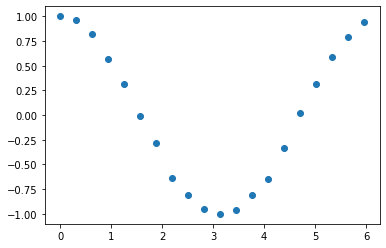

In [6]:
brute_force(m.pi/10, 0.0, 2*m.pi)

Of course, this example is very simple. Our optimizer, for example, really only works because we have a one-parameter system. We might imagine that for more complicated systems, we may need to use every angle in $U_3$, if not even multiple $U_3$'s. In these situations, we should upgrade to better optimizers, like Nelder-Mead, Grid Search (with some ingenuity), or Gradient Descent among many others. Thankfully, qiskit.aqua has a build in optimizer for VQE!


### Notation

For a multi-qubit system, we will often write $\sigma_i^m $ where $m = x, y, z$ and $i$  indicates the qubit we are acting on. For example, $\sigma_3^z$ would be a $Z$ operation acting on the 3rd qubit.

Note that if order to be completely correct, in and $n$ qubit system:

$$ \sigma_i^z = 1_0 \otimes 1_1 \otimes ... \otimes 1_{i-1} \otimes \sigma_i^z \otimes 1_{i+1} \otimes ... \otimes 1_{n-1} $$

(We zero index here.) $1$ here represents the $2 \times 2$ identity matrix for a qubit system. This is to say that writing $\sigma_m^i$ is an abuse of notation, and all the identity operators should be implied.




## The Ising Model

In this notebook, we will talk about the **transverse Ising Model**. We call this model **transverse** because the magnetic field is perpendicular to directions of the spins. That is, if the interaction term is quantized in the $z$ direction, the term proportional to the magnetic field should be in the $x$ or $y$ direction.

Let's start with the simple case of the 1D chain. We can think of this model as a chain of fixed particles that have some given spin, where a magnetic field is being applied.

<img src="Ising_Model_on_a_QC_Images/ising chain.png">

For an $N$ site ising model's Hamiltonian is :


$$ H = - \sum_{\langle i, j \rangle} J_{ij} \sigma_i^z \sigma_j^z - \sum_{i=0}^{N-1} h_{i} \sigma_i^x $$

We often assume $h_i$ and $J_{ij}$ are constant, reducing the model to:

$$ H = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_{i=1}^{N-1} \sigma_i^x $$

For this ising model, assume that our basis states are states with particles polarized in the $z$ direction. So, if we were dealing with spin-$\frac{1}{2}$ particles, our basis states could be expressed as:

$$ \bigotimes_{i=0}^{N-1} | s_i \rangle$$

where $s_i$ is the spin of the $i$th particle.

So each basis state is a tensor product of $N$ single particle states, that can be of any spin. So for the spin-$\frac{1}{2}$ case with two sites, if we let $| +1/2 \rangle = |+ \rangle, |-1/2 \rangle = |- \rangle$, then our basis states are:

$$ |++ \rangle, | +- \rangle, |-+\rangle, |-- \rangle$$

To help build physical intuition, we will discuss the terms proportional to $J$ and $h$ separately. 



### The J Term
**We can think of the term proportional to $J$ to measure the interaction between neighboring spins.** First, note that the notation $\langle i,j \rangle$ counts nearest neighbor pairs, so we effectively operate on site $i$ and $i+1$. Consider the $i$th and $(i+1)$th particle, $|s_i s_{i+1} \rangle$. There are four cases: $ |++ \rangle, | +- \rangle, |-+\rangle, |-- \rangle$. These are all eigenstates of $\sigma_i^{z} \sigma_{i+i}^z$:
$$ \sigma_i^{z} \sigma_{i+i}^z |++ \rangle = |++ \rangle$$
$$ \sigma_i^{z} \sigma_{i+i}^z |+- \rangle = -|+- \rangle$$
$$ \sigma_i^{z} \sigma_{i+i}^z |-+ \rangle = -|-+ \rangle$$
$$ \sigma_i^{z} \sigma_{i+i}^z |-- \rangle = |-- \rangle$$

Notice that the eigenvalue is $+1$ if both of the spins are aligned, and $-1$ if they are not aligned. Thus, the matrix element proportional to $J$ measures neighboring interactions between spins, measure how "aligned" they are. 




### The h Term
**One way to interpret the term proportional to $h$ is to consider a uniform magnetic field applied in the $x$ direction. That is: $\vec{B} = B \hat{x}$ is being applied onto the Ising Chain.** The best way to see this is to invoke some knowledge from Quantum Mechanics. (If you have taken Quantum II, you can make a connection to the Zeeman Effect, since spin magnetic moment and magnetic field interact to create a Hamiltonion proportional to $H = -\vec{\mu} \cdot \vec{B}$, which for a field in the $x$ direction, yields $H \propto -\sigma^x B$)

We will provide some intuition and a quick derivation for why this is true. 

Let's consider a particle with some spin. We might expect that spin, like general angular momentum, would lead to the particle to have some sort of magnetic moment. This magnetic moment is a vector that can be written as:

$$ \vec{\mu} = -\frac{\mu_b g_s \vec{S} }{\hbar}$$

where $\mu_b$ is the Bohr Magneton (which is a given constant), $g_s$ is the Landau g-factor, and $\vec{S}$ is a vector for spin. **Be careful not to confuse $\vec{\mu}$ and $\mu_b$.** The former is the vector that represents the magnetic moment, and the latter is a constant that can be seen as a scaling of $\vec{S}$. The Landau g-factor, $g_s$ also acts as a scaling on spin. We use a subscript $s$ because there also exists a Landau g-factor for other types of angular momenta, like $g_L$. The main take away from all of this is that magnetic moment is directly proportional to spin: $\vec{\mu} \propto \vec{S}$.

If we apply a uniform, magnetic field, $\vec{B}$, we expect the magnetic moment and the magnetic field to interact. This interaction is given by the following Hamiltonian:

$$ H = -\vec{\mu} \cdot \vec{B} $$

Now if we assume that $\vec{B} = B \hat{x}$, then we can simplify!

$$ H = -\vec{\mu} \cdot \vec{B} = - (-\frac{\mu_b g_s \vec{S} }{\hbar}) \cdot B \hat{x}  = \frac{\mu_b g_s}{\hbar} \frac{\hbar}{2} (\vec{\sigma} \cdot \hat{x}) = \frac{\mu_b g_s}{2} \sigma^x $$

We made the substitution that $\vec{S} = \frac{\hbar}{2}\vec{\sigma}$ in the third equality. Letting $h = \frac{\mu_b g_s}{2}$, we get:

$$ H = h \sigma^x$$

which is exactly the term proportional to $h$ in our Ising Model. 




## Solving the Model

Before we go forth and solve the model, we should talk about what "solving a model" means. In physical systems, our goal is generally to find the ground state of a given Hamiltonian. While some systems can be done by hand analytically, we often come across complex systems in, for example, condensed matter where we cannot easily solve the system by hand. We can then turn to computers, and work on numerical solutions.

While the Ising Model can be solved by hand, it is also a great model for building understanding of numerical solutions. For a given $J, h$, our goal is to find the ground state. 

However, we can actually simplify the problem. Instead of considering $H(J,h)$, a Hamiltonian which is a function of two parameters, we will consider $H(h/J)$, a Hamiltonian of one parameter: the ratio of $h$ to $J$. Thus, we have:

$$ H(h/J) = -\sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - \frac{h}{J} \sum_{i=1}^{N-1} \sigma_i^x $$

This is incredibly convenient since now our problem relies only on one parameter. Let's define $\tilde{h} = h/J$ to condense our notation, giving:

$$ H(\tilde{h}) = -\sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - \tilde{h}\sum_{i=1}^{N-1} \sigma_i^x $$

We may wonder if dividing by $J$ will affect our eigenstates and eigenvalues. Recall from linear algebra that for a given matrix $A$ and a constant $b$, the matrices $bA$ and $A$ have the same eigenvectors, and the eigenvalues of $bA$ are just the eigenvalues of $A$ multiplied by $b$. Thus, when we calculate the ground state, the ground state itself will be fine, but we need to scale the ground state energy by $J$ to ensure we get the correct energy. Generally, the ratio $h/J$ will tell us enough.

## Quantum Computation Solution to the Ising Model

In this section, we will discuss how we can use a quantum circuit to solve the Ising Model. Again, when we say "solve the model" our goal is to find the ground state wave function for a given ratio $h/J$. 

We will use the VQE to solve the model. Afterward, we present code for a naive ansatz and a brute force optimizer to solve for the 2 site Ising Model





### Using VQE for the Transverse Ising Model

Now that we have covered enough background, let's discuss how we would use this method for the Transverse Ising Model (TIM). 

Recall that our one-parameter Hamiltonian takes the form:

$$ H(\tilde{h}) = \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - \tilde{h}\sum_{i=1}^{N-1} \sigma_i^x $$

Given a general $| \psi \rangle $, our goal would then to be calculate a series of two matrix elements: $\langle \psi | \sigma_i^z \sigma_{i+1}^z| \psi \rangle $ and $ \langle \psi | \sigma_i^x|\psi \rangle $. (I have adjusted our notation to take the first sum to be $\sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z = \sum_{i=0}^{N-2} \sigma_i^z \sigma_{i+1}^z $. Note that the sum goes to $N-2$ since the last site is site $N-1$, which only interacts with site $N-2$.)

Let's consider a very general ansatz: one that will allow for all linear combinations of $N$ qubit states (without relative phases between them):

$$ |\psi (\vec{\theta}) \rangle = \Pi_{i=0}^{N-1}U(\theta_i)|0 \rangle $$

Here, I write $\vec{\theta}$ to indicate that there are $N$ individual $\theta_i$s. $U(\theta_i)$ is the same rotation operator given earlier, and $| 0\rangle$ is a standard qubit state. We will let each qubit represent a site in the TIM. We will let $|0 \rangle$ be a spin up state, and $| 1 \rangle$ be spin down. For example, in a three qubit system, the state $|010 \rangle$ would be a state with spin ups on site 0 and 2, and a spin down on site 1.




#### Measurements for $\langle H \rangle $

In order to calculate the energy, $\langle H \rangle $, we need to calculate just two matrix elements: $\langle \psi | \sigma_i^z \sigma_{i+1}^z| \psi \rangle $ and $ \langle \psi | \sigma_i^x|\psi \rangle $. By convention, our states are already polarized in the $z$ direction, so the calculation of $\langle \psi | \sigma_i^z \sigma_{i+1}^z| \psi \rangle $ is quite simple. We can run the following circuit:

<img src="Ising_Model_on_a_QC_Images/ZZ Circuit.png">

You might notice that the result of this measurement will only return $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$, and not actually the value of $\langle \psi | \sigma_i^z \sigma_{i+1}^z| \psi \rangle $. However, once we take the measurement using the circuit above, we can calculate $\langle \psi | \sigma_i^z \sigma_{i+1}^z| \psi \rangle $! If we return $|00 \rangle, | 11 \rangle$, the value is $+1$. If it is $|01 \rangle, |10 \rangle$, it is $-1$. We might ask if we can simply apply a $\sigma^z$ operator on both qubits and measure it. This unfortunately does not work because measurements do not capture phases, and a negative sign is just a phase. 

For the $\sigma^x$ measurement, we need to perform some circuit operations to change bases. This is because, by default, our measurements are in the $z$ direction. 

<img src="Ising_Model_on_a_QC_Images/X Circuit.png">

In the diagram above, notice that a Hadamard gate, $H$ gate, is applied before the measurement. We can think of the Hadamard gate as the transformation from the $z$ to the $x$ basis. Mathematically, if we calculate the matrix that does this transformation with $|0 \rangle_x = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1\end{bmatrix}^T$ and $|1 \rangle_x = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -1\end{bmatrix}^T$, the Hadamard gate is exactly the $2 \times 2$ matrix that does this basis transformation. 

If we look strictly at the circuit operations, let's see what happens to $|0 \rangle,|1 \rangle, |0 \rangle_x,|1 \rangle_x$ (where if subscripts are omitted, we assume that this is in the $z$ basis):

$$ H |0 \rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1\end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1\end{bmatrix} = |0 \rangle_x$$
$$ H |1 \rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1\end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ -1\end{bmatrix} = |1 \rangle_x$$

Similarly, $H |0 \rangle_x = |0 \rangle, H |1 \rangle_x = |1 \rangle$. 

Thus, by applying a Hadamard gate to our state in the $z$-basis, we are able to move into the $x$-basis.


## Example in Qiskit

We will now provide some examples in Qiskit! 


In the following example, we consider a Two Site Ising model. The Hamiltonian can be simply expanded as:

$$ H = -J(\sigma^z_0 \sigma^z_1) - h(\sigma^x_0 + \sigma^x_1)$$


We will use the ansatz:

$$ R_0(\theta_0)| 0 \rangle \otimes R_1(\theta_1) | 0 \rangle $$

Where $R(\theta)$ is basically a $U_3(\theta, 0, 0)$ gate. 

### Code

**ansatz(params, qc)** takes in a quantum circuit and the parameters. The parameters come in as a 4 entry np.array, where the 0 and 2 entry correspond to $\theta_0$ and $\theta_1$. (The other two entries, 1 and 3, would correspond to $\phi$s, but currently I don't have that implemented, so I hardcode all $\phi = 0$. 

**expZZ(index, qcO, shots_number = 1024)** takes in the index, which corresponds to the $i$th and $(i+1)$th site that $\sigma^z_i \sigma^z_{i+1}$ measures. It runs a measurement by making a copy of the quantum circuit and measuring in the $z$ basis, before returning $\langle \sigma^z_i \sigma^z_{i+1} \rangle$.

**expX(index, qcO, shots_number = 1024)** takes the index and returns $\langle \sigma^x_i \rangle$. 

**expectations(params, h, shots_number=1024)** takes in the parameters and uses the three functions above to return the expected value of energy. 

**brute_force_2theta(step_size0, step_size1, params_min, params_max, h)** takes in parameter minimums and maximums, as well as the step size we want to change the $\theta_0, theta_1$ by. It graphs all the possibilities given these steps, and then returns the minimum value and a graph of the energy curve as a function of the two thetas. 


In [6]:
def ansatz(params, qc): 
    # params should be a numpy array [theta0, theta1]
    # This is applied in expectation, and it is assumed to be applied on a |00> system
    # Sets theta = param, and the next two to 0. Last argument is the qubit number
    qc.u3(params[0], 0, 0, 0) 
    qc.u3(params[1], 0, 0, 1) 
    return

def expZZ(index, qcO, shots_number = 1024):
    # for a given index, we measure ZZ for index, index+1
    qc = qcO.copy()
    qc.measure(index, 0)
    qc.measure(index + 1, 1)
    backend = BasicAer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=shots_number).result().get_counts()
       
    freq_pos = 0.0
    freq_neg = 0.0
    
    # if 11, 00, return 1
    # if 01, 10, return -1 
    for key in counts.keys():
        if (key == '00') or (key == '11'):
            freq_pos = freq_pos + counts[key]
        else: #01, 10
            freq_neg = freq_neg + counts[key]
    
    # normalizing frequencies
    freq_pos = freq_pos / shots_number
    freq_neg = freq_neg / shots_number
    expZZ = (freq_pos - freq_neg)
    return expZZ


def expX(index, qcO, shots_number = 1024): 
    # for a given index, we measure X for the index
    qc = qcO.copy()
    qc.h(index)
    qc.measure(index, 0) # we always measure to the first, so our results are 00 and 01
    backend = BasicAer.get_backend('qasm_simulator')
    counts = execute(qc, backend, shots=shots_number).result().get_counts()

    freq_pos = 0.0
    freq_neg = 0.0
    
    for key in counts.keys():
        if key == '00': #the result is printed in reverse order
            freq_pos = freq_pos + counts[key]
            
        else:
            freq_neg = freq_neg + counts[key]
            
    freq_pos = freq_pos / shots_number
    freq_neg = freq_neg / shots_number
    expX = freq_pos - freq_neg
    return expX


def expectation(params, h, shots_number = 1024): 
    # We run the quantum circuit. Then, using the resulting measurement, we calculate the expectation value.
    # This function is hard-coded for a this specific H and 2 qubits. We assume we are in the z-basis. 
    
    # Creating the circuit
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q, c)
    
    # Applying the ansatz preparation on a given |0>
    ansatz(params, qc) 
    

    expX_tot = 0.0
    i = 0
    while i < 2:
        expX_tot = expX_tot + expX(i, qc)
        i += 1
        
    X_contribution = -h * expX_tot
    ZZ_contribution = -expZZ(0, qc)
    #print("The X contribution is: " + str(X_contribution))
    #print("The ZZ contribution is: " + str(ZZ_contribution))
    exp =  X_contribution + ZZ_contribution
    return exp

  
def brute_force_2theta(step_size0, step_size1, params_min, params_max, h):
    thetas_0 = np.arange(params_min[0], params_max[0], step_size0)
    thetas_1 = np.arange(params_min[1], params_max[1], step_size1)
    expectations = np.zeros([np.size(thetas_0), np.size(thetas_1)])
    # number of rows is the number of theta 0s, and number of columns is number of theta 1s.

    j =0 # iterating through theta_0
    while j<np.size(thetas_0):
        i=0 # iterating through theta_1
        while i < np.size(thetas_1):
            expectations[j][i] = expectation(np.array([thetas_0[j], thetas_1[i]]), h)
            i += 1
        j += 1
        
    min_value = np.amin(expectations)
    min_index = np.where(expectations == min_value) 
    # returns indices as a tuple of arrays. 
    # i.e. (array([0]), array([1])) for row 0, column 1
    index_theta0 = min_index[0][0]
    index_theta1 = min_index[1][0]
    opt_theta0 = thetas_0[index_theta0]
    opt_theta1 = thetas_1[index_theta1]
    
    print("The minimum expectation value is " + str(min_value) + ", which occurs at position " 
          + str(min_index) + " and corresponds to theta = " + str(opt_theta0) + ", " + str(opt_theta1))
    print(expectations[index_theta0][index_theta1])
    
    T1, T0 = np.meshgrid(thetas_1, thetas_0)
    # I had to swap the order of T1 and T0 because of how I made my expectation array
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T1, T0, expectations)
    ax.set_xlabel('Theta 1 ')
    ax.set_ylabel('Theta 0')
    plt.show()
    contour = plt.contourf(T1, T0, expectations)
    plt.colorbar(contour)
    plt.show()
    return
        

The minimum expectation value is -200.03125, which occurs at position (array([5]), array([5])) and corresponds to theta = 1.5707963267948966, 1.5707963267948966
-200.03125


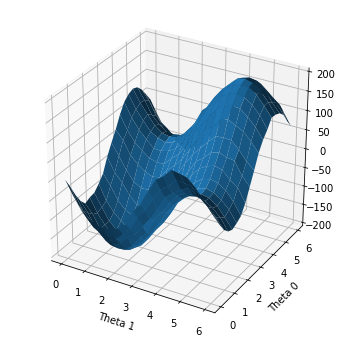

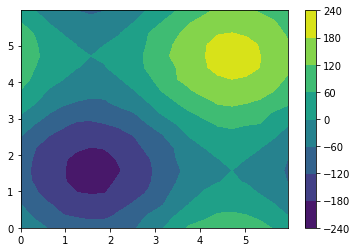

In [7]:
# Running the VQE algorithm
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
h = 100.0 #ratio of h/J

brute_force_2theta(m.pi/10, m.pi/10, np.array([0.0, 0.0]), np.array([2*m.pi, 2*m.pi]), h )


It is worth noting that $h$ is multiplied by $\langle \sigma_x \rangle$, but we might expect some error on the $\sigma_x$ term. For extremely large $h$, for a certain set of parameters, there can be a large amount of variance in the measurement.

## Additional Resources
### Classical Computation Solution to the Ising Model

<font color='red'> We will provide a notebook for a classical calculation later. This is in progress </font>
    
### Ansatz Comparisons

<font color='red'> We will provide a notebook for this comparison, on a 4 site ring. </font>

## Possible Extensions

We present here some possible extensions for projects.



1.   Comparison of Ansatz: We might imagine that the ansatz presented may not be the best ansatz. Run some calculations in an effort to find a better one! (Either one that is closer to the exact energy, requires less iterations, etc.)

2.   Additional terms: This Ising model is quite barebones. Consider the addition of other terms in the Ising Model. 



## References

#### Variational Method:

1.   Griffiths, <font color = 'pink'> I think it's like chapter 5 but idk</font>
2.   Sakurai, 5.4
3.   

#### VQE

1.   http://dkopczyk.quantee.co.uk/vqe/
2.   https://qiskit.org/textbook/ch-applications/vqe-molecules.html

#### Ising Model


#### Quantum Solution to the Ising Model

1.   https://arxiv.org/pdf/1804.03719.pdf

## Image References

Circuit diagrams are from https://arxiv.org/pdf/1804.03719.pdf figure (49).

VQE schematic diagram from Peruzzo et al. https://www.nature.com/articles/ncomms5213